# Tonque survey simulations

This notebook recreates the Tonque experimental survey reported in 

>Wandsnider, L., Camilli, E.L., 1992. The Character of Surface Archaeological Deposits and Its Influence on Survey Accuracy. J. Field Archaeol. 19, 169–188. https://doi.org/10.2307/529977 

I use the `prospect` Python package to simulate the survey under multiple scenarios. The simulations have already been run and saved to disk, so those can be loaded to explore existing results. 

If you'd like to experiment with changes, you can set the variables that start `LOAD_* = None` to re-run the full simulations. 

In [1]:
import pickle
from typing import List

import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import prospect
import seaborn as sns
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from tqdm.notebook import tqdm, trange

In [2]:
sns.set_style("white")
sns.set_context("notebook")

## Functions to run a "perfect" version of the Tonque survey and calculate some summary statistics

In [3]:
def tonque_perfect(
    artifact_group: str, 
    n_seeded_artifacts: int, 
    n_surveys: int = 1000, 
    sweep_width: float=2.0
) -> List[float]:
    """Run a full survey with parameters matching the Tonque project
    
    Parameters
    ----------
    artifact_group : str
        Name of the group, e.g., "white_large"
    n_seeded_artifacts : int
        How many artifacts were seeded from this category
    n_surveys : int
        Number of surveys to run for each artifact group
    sweep_width : float
        Distance on one side of the transect. sweep_width * 2 = transect width
    
    Returns
    -------
    discovery_fracs : List[float]
        A list of length n_surveys where each value is the fraction of seeded 
        artifacts that were recovered in that one iteration of the survey
    """
    target_poisson_rate = n_seeded_artifacts / 160000

    # 400 x 400 meter area
    area = prospect.Area.from_area_value(name="Tonque", value=160000, vis=1.0)

    # Transects spaced 5 meters apart
    coverage = prospect.Coverage.from_transects(
        name="tonque_transects", area=area, spacing=5, sweep_width=sweep_width
    )

    # A single surveyor that finds everything they encounter
    surveyor = prospect.Surveyor(
        name="perfecto", team_name="single_perfect", surveyor_type="expert", skill=1.0
    )
    team = prospect.Team(name="single_perfect", surveyor_list=[surveyor])

    discovery_fracs = []
    for _ in trange(n_surveys):
        try:
            # Create artifact layer in a loop to guarantee number 
            # matches Camilli and Wandsnider 
            n_artifacts = 0
            while n_artifacts != n_seeded_artifacts:
                artifacts = prospect.Layer.from_poisson_points(
                    rate=target_poisson_rate, 
                    name=f"{artifact_group}", 
                    area=area, 
                    ideal_obs_rate=1.0
                )
                n_artifacts = artifacts.df.shape[0]

            # Single-layer assemblage
            assemblage = prospect.Assemblage(name="washers", layer_list=[artifacts])
            # Initialize Survey
            survey = prospect.Survey(
                name=f"tonque_{artifact_group}", 
                area=area, 
                assemblage=assemblage, 
                coverage=coverage, 
                team=team
            )
            # Run Survey
            n_runs = 1
            survey.run(n_runs=n_runs)
            # Calculate the fraction of the original seeded artifacts that were found
            discovery_fracs.append(
                (
                    (
                        survey.discovery["discovery_prob"] >= 0.9
                    ).sum() / n_runs) / artifacts.df.shape[0]
            )
        except:
            discovery_fracs.append(0.0)

    return discovery_fracs

In [4]:
def tonque_perfect_stats(discovery_fracs: List[float], obs_frac: float) -> None:
    """Generate some summary statistics for the results of tonque_perfect()
    
    Parameters
    ----------
    discovery_fracs : List[float]
        List identical to the output of tonque_perfect()
    obs_frac : float
        Fraction of artifacts recovered by Camilli and Wandsnider
    
    Returns
    -------
    None    
    """
    
    print(f"Mean artifacts discovered: {np.mean(discovery_fracs)}")
    print(f"Std Dev: {np.std(discovery_fracs)}")
    print(f"Min/Max: {np.min(discovery_fracs)}, {np.max(discovery_fracs)}")
    frac_lte_obs = (
        len([val for val in discovery_fracs if val <= obs_frac]) / len(discovery_fracs)
    )
    print(f"Fraction of 'perfect' surveys at or below observed: {frac_lte_obs}\n")

In [5]:
# Color scheme based on ColorBrewer2.org qualitative "8-class Paired"
AREA_LT_BLUE = "#a6cee3"
COVERAGE_BLUE = "#1f78b4"
LAYER_GREEN = {"facecolor": "#33a02c", "edgecolor": "#b2df8a"}

def tonque_perfect_plot(
    artifact_group: str, 
    n_seeded_artifacts: int, 
    sweep_width: float=2.0
) -> None:
    """Generate plot of building blocks of the simulation
    
    Parameters
    ----------
    artifact_group : str
        Name of the group, e.g., "white_large"
    n_seeded_artifacts : int
        How many artifacts were seeded from this category
    sweep_width : float
        Distance on one side of the transect. sweep_width * 2 = transect width
    
    Returns
    -------
    None
    """
    
    target_poisson_rate = n_seeded_artifacts / 160000

    # 400 x 400 meter area
    area = prospect.Area.from_area_value(name="Tonque", value=160000, vis=1.0)

    # Transects spaced 5 meters apart
    coverage = prospect.Coverage.from_transects(name="tonque_transects", area=area, spacing=5, sweep_width=sweep_width)

    # A single surveyor that finds everything they encounter
    surveyor = prospect.Surveyor(name="perfecto", team_name="single_perfect", surveyor_type="expert", skill=1.0)
    team = prospect.Team(name="single_perfect", surveyor_list=[surveyor])

    # Create artifact layer in a loop to guarantee number matches Camilli and Wandsnider 
    n_artifacts = 0
    while n_artifacts != n_seeded_artifacts:
        artifacts = prospect.Layer.from_poisson_points(rate=target_poisson_rate, name=f"{artifact_group}", area=area, ideal_obs_rate=1.0)
        n_artifacts = artifacts.df.shape[0]

    # Single-layer assemblage
    assemblage = prospect.Assemblage(name="washers", layer_list=[artifacts])

    survey = prospect.Survey(name=f"tonque_{artifact_group}", area=area, assemblage=assemblage, coverage=coverage, team=team)

#     n_runs = 1
#     survey.run(n_runs=n_runs)

    fig, ax = plt.subplots(2, 2, figsize=(12, 8))

    # Area
    ax[0][0].set_title("Area", size="x-large", pad=0)
    area.df.plot(ax=ax[0][0], color=AREA_LT_BLUE)

    # Assemblage
    ax[0][1].set_title("Assemblage", size="x-large", pad=0)
    area.df.plot(ax=ax[0][1], facecolor="none", edgecolor=AREA_LT_BLUE)
    assemblage.df.plot(ax=ax[0][1], facecolor=LAYER_GREEN["facecolor"], edgecolor=LAYER_GREEN["edgecolor"])

    # Coverage
    ax[1][0].set_title("Coverage", size="x-large", pad=0)
    area.df.plot(ax=ax[1][0], facecolor="none", edgecolor=AREA_LT_BLUE)
    coverage.df.plot(ax=ax[1][0], color=COVERAGE_BLUE)

    # Combined
    ax[1][1].set_title("Combined", size="x-large", pad=0)
    area.df.plot(ax=ax[1][1], color=AREA_LT_BLUE)
    coverage.df.plot(ax=ax[1][1], facecolor=COVERAGE_BLUE, edgecolor="none")
    assemblage.df.plot(ax=ax[1][1], facecolor=LAYER_GREEN["facecolor"], edgecolor=LAYER_GREEN["edgecolor"])

    scalebar = AnchoredSizeBar(
        ax[1][1].transData,
        100, 
        "100 m", 
        "lower right", 
        pad=-0.2,
        color="black",
        frameon=False,
        size_vertical=1)
    ax[1][1].add_artist(scalebar)

    for sub_ax in fig.axes:
        sub_ax.axis("off")
    sns.despine(left=True, bottom=True)
    plt.tight_layout()

## Run an example of a single simulation's building blocks

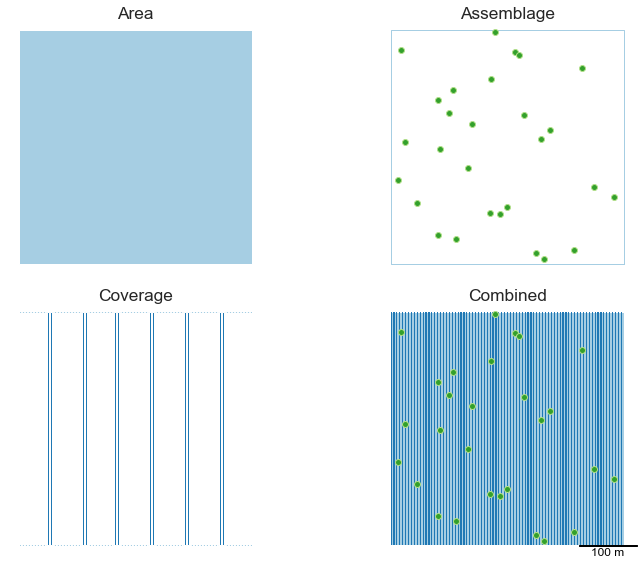

In [6]:
tonque_perfect_plot(artifact_group="white_large", n_seeded_artifacts=28, sweep_width=1.0)

## Set the relevant parameters to match values in Camilli and Wandsnider

In [7]:
tonque_configs = [
    {
        "artifact_group": "white_large",
        "n_seeded_artifacts": 28,
        "obs_frac": 0.71
    },
    {
        "artifact_group": "white_medium",
        "n_seeded_artifacts": 43,
        "obs_frac": 0.47
    },
    {
        "artifact_group": "white_small",
        "n_seeded_artifacts": 40,
        "obs_frac": 0.70
    },
    {
        "artifact_group": "brown_large",
        "n_seeded_artifacts": 26,
        "obs_frac": 0.62
    },
    {
        "artifact_group": "brown_medium",
        "n_seeded_artifacts": 44,
        "obs_frac": 0.30
    },
    {
        "artifact_group": "brown_small",
        "n_seeded_artifacts": 43,
        "obs_frac": 0.23
    },
    {
        "artifact_group": "black_large",
        "n_seeded_artifacts": 23,
        "obs_frac": 0.65
    },
    {
        "artifact_group": "black_medium",
        "n_seeded_artifacts": 43,
        "obs_frac": 0.37
    },
    {
        "artifact_group": "black_small",
        "n_seeded_artifacts": 38,
        "obs_frac": 0.53
    },
]

## 2m transect widths

These surveys use 2 meter transect widths (1 meter on each side)

### Build and run the surveys (or load from disk)

In [8]:
LOAD_FROM_PATH = "./datasets/tonque_survey_results_2m_transect_width.pkl"


if LOAD_FROM_PATH is not None:
    with open(LOAD_FROM_PATH, mode="rb") as tonque_file:
        tonque_results_2m = pickle.load(tonque_file)

else:
    tonque_results_2m = tonque_configs.copy()
    for config in tonque_results_2m:
        discovery_fracs = tonque_perfect(
            artifact_group=config["artifact_group"], 
            n_seeded_artifacts=config["n_seeded_artifacts"], 
            n_surveys=2000, 
            sweep_width=1
        )
        config["discovery_fracs"] = discovery_fracs
    
    with open("./datasets/tonque_survey_results_2m_transect_width.pkl", mode="wb") as tonque_file:
        pickle.dump(tonque_results_2m, tonque_file)

In [9]:
tonque_results_2m[0].keys()

dict_keys(['artifact_group', 'n_seeded_artifacts', 'obs_frac', 'discovery_fracs'])

In [10]:
for result_set in tonque_results_2m:
    print(result_set["artifact_group"])
    tonque_perfect_stats(discovery_fracs=result_set["discovery_fracs"], obs_frac=result_set["obs_frac"])

white_large
Mean artifacts discovered: 0.40303571428571433
Std Dev: 0.09308882498310253
Min/Max: 0.07142857142857142, 0.75
Fraction of 'perfect' surveys at or below observed: 0.9995

white_medium
Mean artifacts discovered: 0.40118604651162787
Std Dev: 0.07594367201835998
Min/Max: 0.16279069767441862, 0.6744186046511628
Fraction of 'perfect' surveys at or below observed: 0.843

white_small
Mean artifacts discovered: 0.3993
Std Dev: 0.07940881563151538
Min/Max: 0.15, 0.675
Fraction of 'perfect' surveys at or below observed: 1.0

brown_large
Mean artifacts discovered: 0.40069230769230774
Std Dev: 0.09808277508936403
Min/Max: 0.07692307692307693, 0.7692307692307693
Fraction of 'perfect' surveys at or below observed: 0.994

brown_medium
Mean artifacts discovered: 0.40181818181818174
Std Dev: 0.07514311414431654
Min/Max: 0.11363636363636363, 0.6363636363636364
Fraction of 'perfect' surveys at or below observed: 0.0995

brown_small
Mean artifacts discovered: 0.4031395348837209
Std Dev: 0.0734

### Turn results in a pandas DataFrame for easier plotting with seaborn

Each row is a unique run of the survey.

In [11]:
LOAD_RESULTS_FROM_PATH = "./datasets/tonque_survey_results_2m_transect_width.csv"

if LOAD_RESULTS_FROM_PATH is not None:
    results_df = pd.read_csv(LOAD_RESULTS_FROM_PATH).loc[:, ["discovery_frac", "artifact_group", "obs_frac", "color", "size"]]

else:
    # Make DataFrame with columns for "discovery_frac", "artifact_group", "obs_frac", "color", "size"
    artifact_group_dfs = []
    for result_set in tonque_results_2m:
        artifact_group_df = pd.DataFrame(
            {
                "discovery_frac": result_set["discovery_fracs"],
                "artifact_group": [result_set["artifact_group"]] * len(result_set["discovery_fracs"]),
                "obs_frac": [result_set["obs_frac"]] * len(result_set["discovery_fracs"]),
            }
        )

        artifact_group_dfs.append(artifact_group_df)

    results_df = pd.concat(artifact_group_dfs, axis=0)
    # Parse the artifact_group string to get the color and size as categorical
    results_df[["color", "size"]] = results_df["artifact_group"].str.split("_", expand=True)

    results_df.to_csv("./datasets/tonque_survey_results_2m_transect_width.csv")

results_df.head()

,discovery_frac,artifact_group,obs_frac,color,size
0,0.428571,white_large,0.71,white,large
1,0.357143,white_large,0.71,white,large
2,0.392857,white_large,0.71,white,large
3,0.535714,white_large,0.71,white,large
4,0.464286,white_large,0.71,white,large


### Plot all nine color/size combinations

In [12]:
# Prepare this list to use in labeling
obs_fracs = results_df.groupby(["artifact_group"], sort=False)["obs_frac"].max().tolist()
obs_fracs

[0.71, 0.47, 0.7, 0.62, 0.3, 0.23, 0.65, 0.37, 0.53]

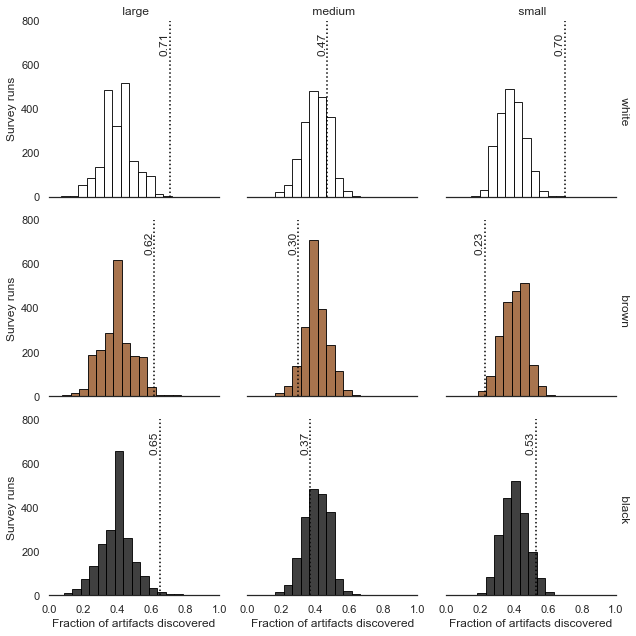

In [13]:
# Create a 3x3 grid where each plot is a unique color/size combination
g = sns.FacetGrid(
    results_df, 
    col="size", 
    row="color", 
    hue="color", 
    palette=["white", "saddlebrown", "black"], 
    xlim=(0,1), 
    ylim=(0, 800), 
    margin_titles=True
)
# Fill the grid with histograms of discovery_frac
g.map(sns.histplot, "discovery_frac", binwidth=0.05, edgecolor="black")

# Style the plot
g.set_axis_labels("Fraction of artifacts discovered", "Survey runs")
g.set(yticks=[0, 200, 400, 600, 800])
# Loop over each subplot
for i, ax in enumerate(g.axes.flat):
    # Make title more human-readable
    if ax.get_title():
        # Get only part after "="
        ax.set_title(
            ax.get_title().split('=')[1],
        )
    # Make right-margin labels more human-readable
    # These are stored as the first entry in ax.texts
    # only on the right-most plots
    if ax.texts:
        # Reconstruct the label, using only the part after "="
        txt=ax.texts[0]
        ax.text(
            txt.get_unitless_position()[0], txt.get_unitless_position()[1], 
            txt.get_text().split("=")[1],
            transform=ax.transAxes,
            va='center',
            rotation=-90
        )
        # Drop the old label
        ax.texts[0].remove()

    # Draw a vertical line representing the fraction observed by Camilli and Wandsnider
    # for this color/size combination
    ax.axvline(obs_fracs[i], color="black", linestyle=":")
    # Label the vertical line with the precise value
    ax.text(obs_fracs[i] - 0.06, 650, f"{obs_fracs[i]:.2f}", rotation=90)
# Drop the left, right, and top spines    
sns.despine(left=True)
plt.tight_layout()
plt.savefig("./plots/tonque_survey_results_2m_transect_width.png", dpi=300)

## 3 meter transect widths

These surveys use 3 meter transect widths (1.5 meters on each side)

### Build and run the surveys (or load from disk)

In [14]:
LOAD_FROM_PATH = "./datasets/tonque_survey_results_3m_transect_width.pkl"


if LOAD_FROM_PATH is not None:
    with open(LOAD_FROM_PATH, mode="rb") as tonque_file:
        tonque_results_3m = pickle.load(tonque_file)

else:
    tonque_results_3m = tonque_configs.copy()
    for config in tonque_results_3m:
        discovery_fracs = tonque_perfect(
            artifact_group=config["artifact_group"], 
            n_seeded_artifacts=config["n_seeded_artifacts"], 
            n_surveys=2000, 
            sweep_width=1.5
        )
        config["discovery_fracs"] = discovery_fracs
    
    with open("./datasets/tonque_survey_results_3m_transect_width.pkl", mode="wb") as tonque_file:
        pickle.dump(tonque_results_3m, tonque_file)

In [15]:
tonque_results_3m[0].keys()

dict_keys(['artifact_group', 'n_seeded_artifacts', 'obs_frac', 'discovery_fracs'])

In [16]:
for result_set in tonque_results_3m:
    print(result_set["artifact_group"])
    tonque_perfect_stats(discovery_fracs=result_set["discovery_fracs"], obs_frac=result_set["obs_frac"])

white_large
Mean artifacts discovered: 0.5988392857142857
Std Dev: 0.09302487426566541
Min/Max: 0.32142857142857145, 0.8571428571428571
Fraction of 'perfect' surveys at or below observed: 0.848

white_medium
Mean artifacts discovered: 0.6
Std Dev: 0.0727836388582736
Min/Max: 0.3488372093023256, 0.813953488372093
Fraction of 'perfect' surveys at or below observed: 0.0465

white_small
Mean artifacts discovered: 0.603275
Std Dev: 0.07594339586165476
Min/Max: 0.3, 0.875
Fraction of 'perfect' surveys at or below observed: 0.932

brown_large
Mean artifacts discovered: 0.602153846153846
Std Dev: 0.09566540556797534
Min/Max: 0.19230769230769232, 0.9230769230769231
Fraction of 'perfect' surveys at or below observed: 0.6095

brown_medium
Mean artifacts discovered: 0.5985113636363636
Std Dev: 0.07262638510222388
Min/Max: 0.38636363636363635, 0.8409090909090909
Fraction of 'perfect' surveys at or below observed: 0.0

brown_small
Mean artifacts discovered: 0.6019767441860465
Std Dev: 0.073867051285

### Turn results in a pandas DataFrame for easier plotting with seaborn

Each row is a unique run of the survey.

In [17]:
LOAD_RESULTS_FROM_PATH = "./datasets/tonque_survey_results_3m_transect_width.csv"

if LOAD_RESULTS_FROM_PATH is not None:
    results_df = pd.read_csv(LOAD_RESULTS_FROM_PATH).loc[:, ["discovery_frac", "artifact_group", "obs_frac", "color", "size"]]

else:
    # Make DataFrame with columns for "discovery_frac", "artifact_group", "obs_frac", "color", "size"
    artifact_group_dfs = []
    for result_set in tonque_results_3m:
        artifact_group_df = pd.DataFrame(
            {
                "discovery_frac": result_set["discovery_fracs"],
                "artifact_group": [result_set["artifact_group"]] * len(result_set["discovery_fracs"]),
                "obs_frac": [result_set["obs_frac"]] * len(result_set["discovery_fracs"]),
            }
        )

        artifact_group_dfs.append(artifact_group_df)

    results_df = pd.concat(artifact_group_dfs, axis=0)
    # Parse the artifact_group string to get the color and size as categorical
    results_df[["color", "size"]] = results_df["artifact_group"].str.split("_", expand=True)

    results_df.to_csv("./datasets/tonque_survey_results_3m_transect_width.csv")

results_df.head()

,discovery_frac,artifact_group,obs_frac,color,size
0,0.607143,white_large,0.71,white,large
1,0.607143,white_large,0.71,white,large
2,0.607143,white_large,0.71,white,large
3,0.607143,white_large,0.71,white,large
4,0.500000,white_large,0.71,white,large


### Plot all nine color/size combinations

In [18]:
# Prepare this list to use in labeling
obs_fracs = results_df.groupby(["artifact_group"], sort=False)["obs_frac"].max().tolist()
obs_fracs

[0.71, 0.47, 0.7, 0.62, 0.3, 0.23, 0.65, 0.37, 0.53]

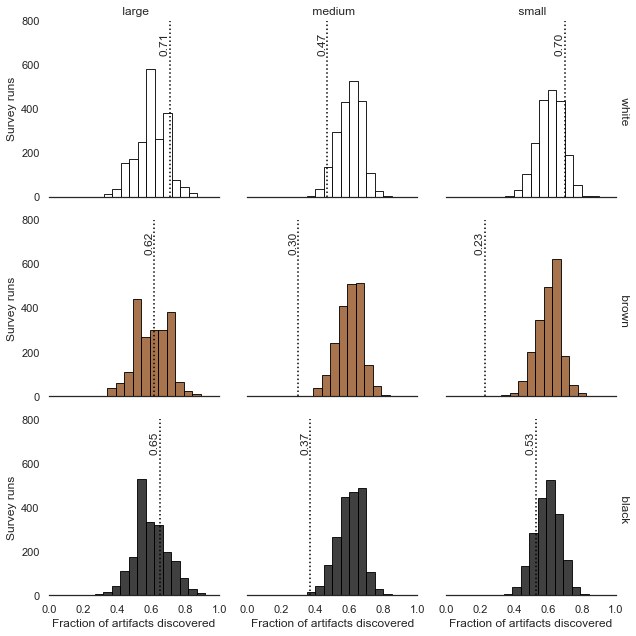

In [19]:
# Create a 3x3 grid where each plot is a unique color/size combination
g = sns.FacetGrid(
    results_df, 
    col="size", 
    row="color", 
    hue="color", 
    palette=["white", "saddlebrown", "black"], 
    xlim=(0,1), 
    ylim=(0, 800), 
    margin_titles=True
)
# Fill the grid with histograms of discovery_frac
g.map(sns.histplot, "discovery_frac", binwidth=0.05, edgecolor="black")

# Style the plot
g.set_axis_labels("Fraction of artifacts discovered", "Survey runs")
g.set(yticks=[0, 200, 400, 600, 800])
# Loop over each subplot
for i, ax in enumerate(g.axes.flat):
    # Make title more human-readable
    if ax.get_title():
        # Get only part after "="
        ax.set_title(
            ax.get_title().split('=')[1],
        )
    # Make right-margin labels more human-readable
    # These are stored as the first entry in ax.texts
    # only on the right-most plots
    if ax.texts:
        # Reconstruct the label, using only the part after "="
        txt=ax.texts[0]
        ax.text(
            txt.get_unitless_position()[0], txt.get_unitless_position()[1], 
            txt.get_text().split("=")[1],
            transform=ax.transAxes,
            va='center',
            rotation=-90
        )
        # Drop the old label
        ax.texts[0].remove()

    # Draw a vertical line representing the fraction observed by Camilli and Wandsnider
    # for this color/size combination
    ax.axvline(obs_fracs[i], color="black", linestyle=":")
    # Label the vertical line with the precise value
    ax.text(obs_fracs[i] - 0.06, 650, f"{obs_fracs[i]:.2f}", rotation=90)
# Drop the left, right, and top spines    
sns.despine(left=True)
plt.tight_layout()
plt.savefig("./plots/tonque_survey_results_3m_transect_width.png", dpi=300)